In [3]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('/content/data.csv')

# Display first few rows
data.head()


,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from category_encoders import TargetEncoder



In [4]:

X = data.drop("income", axis=1)
y = data["income"].map({'<=50K': 0, '>50K': 1})

In [6]:

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [9]:
# Step 5: Create preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_encoder', TargetEncoder())
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])


In [10]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Step 6: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train the model
pipeline.fit(X_train, y_train)

# Step 8: Make predictions
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:42:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89      4976
        >50K       0.67      0.53      0.60      1537

    accuracy                           0.83      6513
   macro avg       0.77      0.73      0.74      6513
weighted avg       0.82      0.83      0.82      6513



In [13]:

cm = confusion_matrix(y_test, y_pred)
fig_cm = go.Figure(data=go.Heatmap(
    z=cm, x=['<=50K', '>50K'], y=['<=50K', '>50K'],
    text=cm, texttemplate="%{text}", colorscale='Blues'
))
fig_cm.update_layout(title='Confusion Matrix', xaxis_title='Predicted', yaxis_title='Actual')
fig_cm.write_html('confusion_matrix.html')

In [14]:
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = list(categorical_cols) + list(numerical_cols)  # TargetEncoder keeps original column names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)

fig_fi = px.bar(feature_importance, x='Feature', y='Importance', title='Top 10 Feature Importances')
fig_fi.update_layout(xaxis_title='Feature', yaxis_title='Importance')
fig_fi.write_html('feature_importance.html')

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)

print("\nTop 10 Feature Importances saved to 'feature_importance.csv'")
print("Confusion matrix saved as 'confusion_matrix.html'")
print("Feature importance plot saved as 'feature_importance.html'")


Top 10 Feature Importances saved to 'feature_importance.csv'
Confusion matrix saved as 'confusion_matrix.html'
Feature importance plot saved as 'feature_importance.html'


<ipython-input-18-3231f06378c6>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Feature')

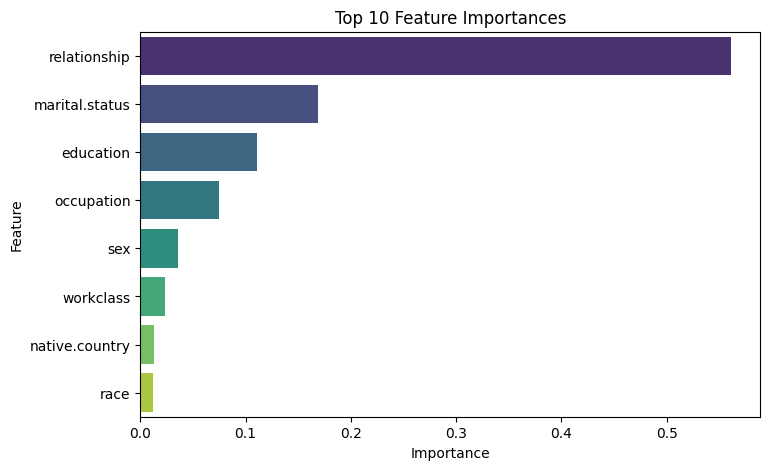

In [18]:
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = list(categorical_cols) + list(numerical_cols)  # TargetEncoder keeps original column names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')


Text(0.5, 1.0, 'Confusion Matrix')

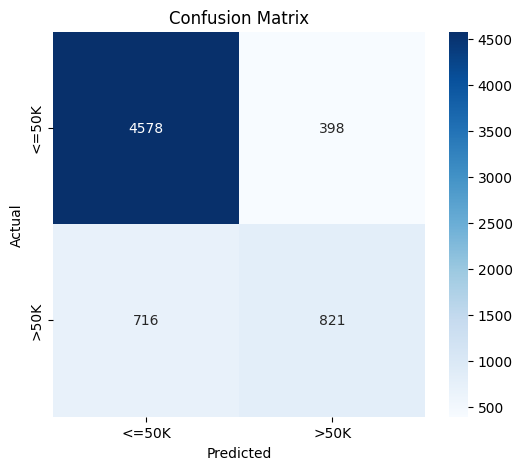

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')